<a href="https://colab.research.google.com/github/harishkulkarni10/Credit-Card-Fraud-Detection/blob/development/notebooks/03_model_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

In [1]:
# Load scaled tensors from Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
drive_path = "/content/drive/MyDrive/Data Science course/Major Projects/Projects/Credit Card Fraud Detection/Credit Card Fraud Detection/data/scaled_tensors.pth"
data = torch.load(drive_path)

X_train = data['X_train'].numpy()
X_val   = data['X_val'].numpy()
y_train = data['y_train'].numpy().ravel()
y_val   = data['y_val'].numpy().ravel()
feature_cols = data['feature_cols']

print(f"Loaded → X_train: {X_train.shape}, fraud %: {y_train.mean():.5f}")

Mounted at /content/drive
Loaded → X_train: (226980, 30), fraud %: 0.00167


In [2]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
import time

start = time.time()
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   # handling imbalance
    n_jobs=-1
)
logreg.fit(X_train, y_train)
training_time = time.time() - start

print(f"Logistic Regression trained in {training_time:.2f} seconds")

Logistic Regression trained in 2.25 seconds


In [3]:
# Predict + Evaluate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_proba = logreg.predict_proba(X_val)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_proba)
precision = precision_score(y_val, y_pred)
recall    = recall_score(y_val, y_pred)
f1        = f1_score(y_val, y_pred)

print(f"AUC        : {auc:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"F1         : {f1:.4f}")

AUC        : 0.9623
Precision  : 0.0547
Recall     : 0.8737
F1         : 0.1030


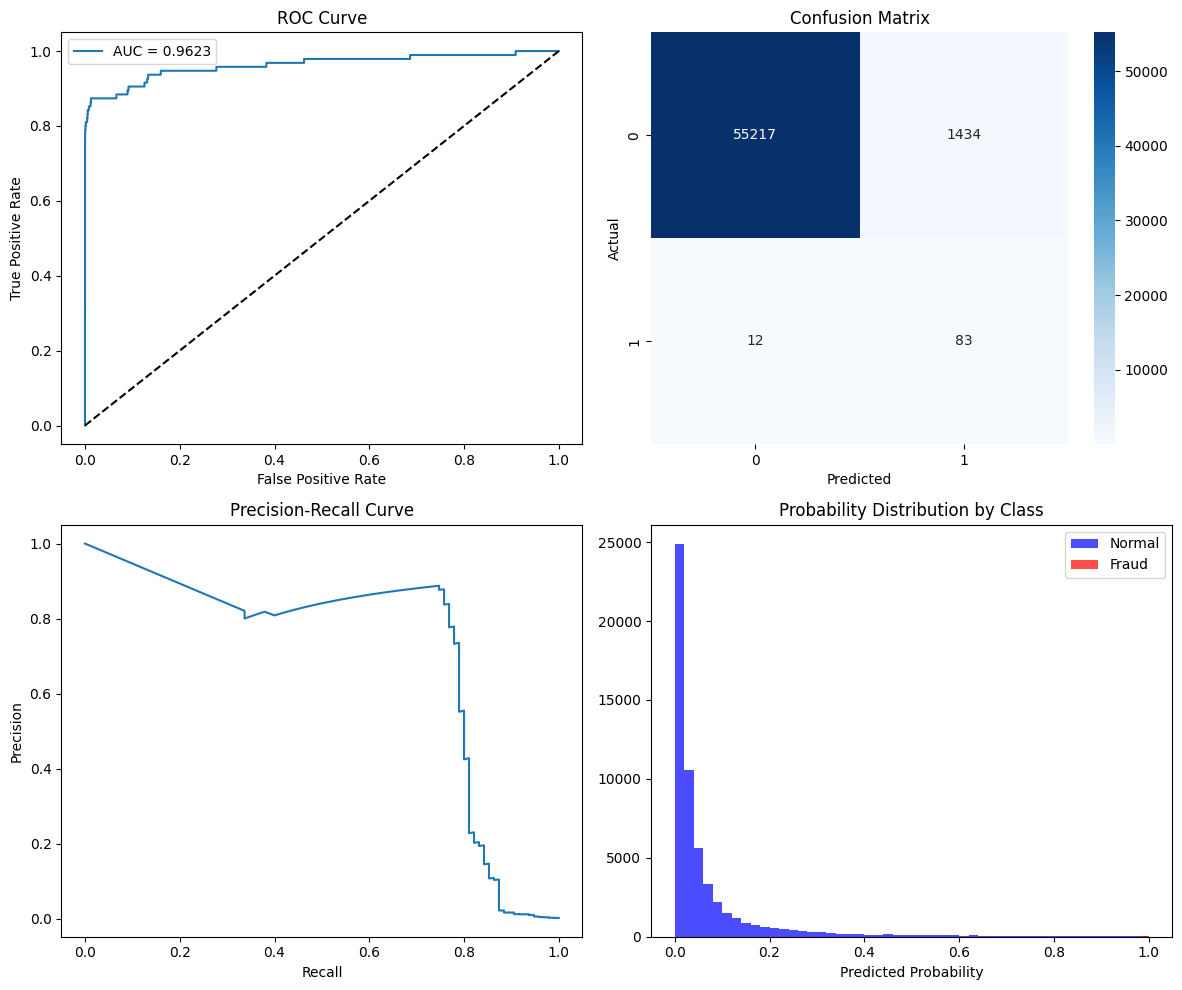

In [4]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 4.1 ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
axes[0,0].plot(fpr, tpr, label=f'AUC = {auc:.4f}')
axes[0,0].plot([0,1],[0,1],'k--')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()

# 4.2 Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 4.3 Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
prec, rec, _ = precision_recall_curve(y_val, y_proba)
axes[1,0].plot(rec, prec)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')

# 4.4 Probability Distribution
axes[1,1].hist(y_proba[y_val==0], bins=50, alpha=0.7, label='Normal', color='blue')
axes[1,1].hist(y_proba[y_val==1], bins=50, alpha=0.7, label='Fraud', color='red')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_title('Probability Distribution by Class')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [5]:
# Save Logistic Regression Model to Drive
import joblib
import os

model_path = "/content/drive/MyDrive/Data Science course/Major Projects/Projects/Credit Card Fraud Detection/Credit Card Fraud Detection/models/logistic_regression.pkl"

os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(logreg, model_path)

print(f"Logistic Regression saved → {model_path}")
print("Metrics:")
print(f"  AUC: {auc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

Logistic Regression saved → /content/drive/MyDrive/Data Science course/Major Projects/Projects/Credit Card Fraud Detection/Credit Card Fraud Detection/models/logistic_regression.pkl
Metrics:
  AUC: 0.9623 | Precision: 0.0547 | Recall: 0.8737 | F1: 0.1030


# XGBoost

In [6]:
!pip install xgboost -q
import xgboost as xgb
import time
print("XGBoost ready!")

XGBoost ready!


In [7]:
# Train XGBoost
import xgboost as xgb
import time
import numpy as np

start = time.time()

scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# DMatrix (required for xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1
}

evals = [(dtrain, 'train'), (dval, 'val')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    callbacks=[xgb.callback.EarlyStopping(rounds=30, metric_name='auc')],
    verbose_eval=10
)

# Save booster to model
xgb_model = xgb.XGBClassifier()
xgb_model._Booster = bst

training_time = time.time() - start
print(f"\nXGBoost trained in {training_time:.2f}s")
print(f"Best iteration: {bst.best_iteration}")

[0]	train-auc:0.98855	val-auc:0.93553
[10]	train-auc:0.99943	val-auc:0.95662
[20]	train-auc:0.99967	val-auc:0.96453
[30]	train-auc:0.99980	val-auc:0.96874
[40]	train-auc:0.99984	val-auc:0.97238
[50]	train-auc:0.99986	val-auc:0.97306
[60]	train-auc:0.99987	val-auc:0.97840
[70]	train-auc:0.99987	val-auc:0.97810
[80]	train-auc:0.99991	val-auc:0.97830
[90]	train-auc:0.99992	val-auc:0.97940
[100]	train-auc:0.99994	val-auc:0.97937
[110]	train-auc:0.99995	val-auc:0.97950
[120]	train-auc:0.99995	val-auc:0.98063
[130]	train-auc:0.99995	val-auc:0.97994
[140]	train-auc:0.99996	val-auc:0.97781
[150]	train-auc:0.99996	val-auc:0.97671
[151]	train-auc:0.99996	val-auc:0.97691

XGBoost trained in 23.74s
Best iteration: 122


In [8]:
# Predict & evaluate using Booster
y_proba_xgb = bst.predict(dval)
y_pred_xgb  = (y_proba_xgb >= 0.5).astype(int)

auc_xgb = roc_auc_score(y_val, y_proba_xgb)
precision_xgb = precision_score(y_val, y_pred_xgb)
recall_xgb    = recall_score(y_val, y_pred_xgb)
f1_xgb        = f1_score(y_val, y_pred_xgb)

print(f"XGBoost → AUC: {auc_xgb:.4f} | Precision: {precision_xgb:.4f} | Recall: {recall_xgb:.4f} | F1: {f1_xgb:.4f}")

XGBoost → AUC: 0.9770 | Precision: 0.7379 | Recall: 0.8000 | F1: 0.7677


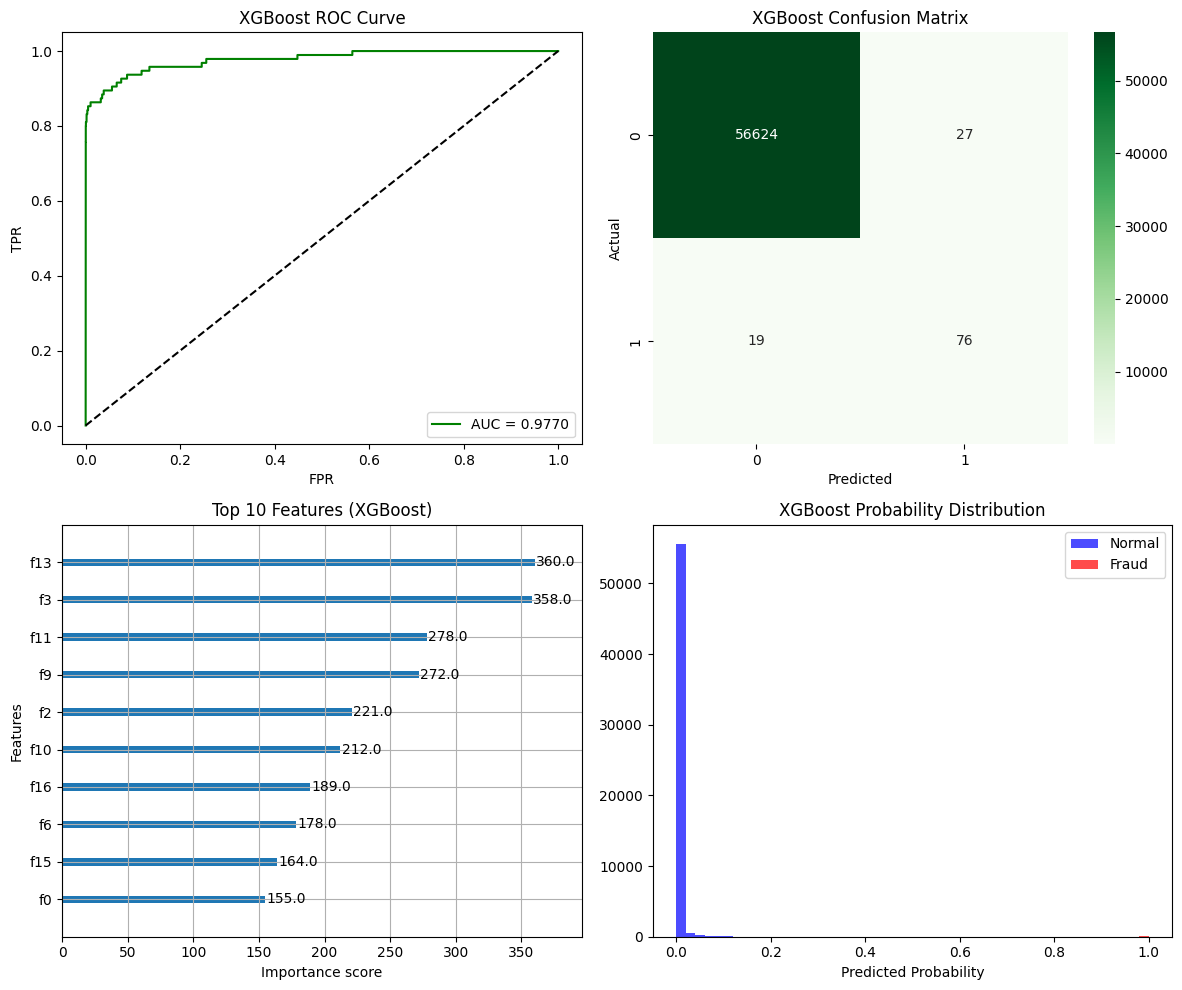

In [9]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 9.1 ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba_xgb)
axes[0,0].plot(fpr, tpr, label=f'AUC = {auc_xgb:.4f}', color='green')
axes[0,0].plot([0,1],[0,1],'k--')
axes[0,0].set_xlabel('FPR')
axes[0,0].set_ylabel('TPR')
axes[0,0].set_title('XGBoost ROC Curve')
axes[0,0].legend()

# 9.2 Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('XGBoost Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 9.3 Feature Importance
xgb.plot_importance(xgb_model, max_num_features=10, ax=axes[1,0])
axes[1,0].set_title('Top 10 Features (XGBoost)')

# 9.4 Probability Distribution
axes[1,1].hist(y_proba_xgb[y_val==0], bins=50, alpha=0.7, label='Normal', color='blue')
axes[1,1].hist(y_proba_xgb[y_val==1], bins=50, alpha=0.7, label='Fraud', color='red')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_title('XGBoost Probability Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [10]:
# Save XGBoost model
model_path = "/content/drive/MyDrive/Data Science course/Major Projects/Projects/Credit Card Fraud Detection/Credit Card Fraud Detection/models/xgboost_model.pkl"

os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(xgb_model, model_path)

print(f"XGBoost model saved → {model_path}")
print("Final Metrics:")
print(f"  AUC: {auc_xgb:.4f} | Precision: {precision_xgb:.4f} | Recall: {recall_xgb:.4f} | F1: {f1_xgb:.4f}")

XGBoost model saved → /content/drive/MyDrive/Data Science course/Major Projects/Projects/Credit Card Fraud Detection/Credit Card Fraud Detection/models/xgboost_model.pkl
Final Metrics:
  AUC: 0.9770 | Precision: 0.7379 | Recall: 0.8000 | F1: 0.7677


# MLP on PyTorch

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Convert numpy arrays to torch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size = 256, shuffle = True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size = 256, shuffle = False)

class FraudMLP(nn.Module):
  def __init__(self, input_dim = 30):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

  def forward(self, x):
    return self.network(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FraudMLP().to(device)

pos_weight = torch.tensor(578.0).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

print(f"Model on: {device}")
print(f"Total batches per epoch: {len(train_loader)}")

Model on: cuda
Total batches per epoch: 887


In [12]:
from sklearn.metrics import roc_auc_score

model.train()
epochs = 15
train_losses = []
val_aucs = []

for epoch in range(epochs):
  epoch_loss = 0.0
  for x_batch, y_batch in train_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    logits = model(x_batch)
    # Reshape y_batch to match logits shape: [batch_size, 1]
    loss = criterion(logits, y_batch.unsqueeze(1))
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  avg_loss = epoch_loss / len(train_loader)
  train_losses.append(epoch_loss / len(train_loader))

  # Val AUC
  model.eval()
  with torch.no_grad():
    val_logits = model(X_val_tensor.to(device))
    val_proba = torch.sigmoid(val_logits).cpu().numpy().ravel()
    val_auc = roc_auc_score(y_val, val_proba)
    val_aucs.append(val_auc)

  model.train()
  print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | Val AUC: {val_auc:.4f}")

Epoch 1/15 - Loss: 0.6269 | Val AUC: 0.9535
Epoch 2/15 - Loss: 0.3239 | Val AUC: 0.9609
Epoch 3/15 - Loss: 0.2666 | Val AUC: 0.9584
Epoch 4/15 - Loss: 0.2913 | Val AUC: 0.9606
Epoch 5/15 - Loss: 0.2559 | Val AUC: 0.9575
Epoch 6/15 - Loss: 0.2104 | Val AUC: 0.9573
Epoch 7/15 - Loss: 0.1861 | Val AUC: 0.9592
Epoch 8/15 - Loss: 0.1807 | Val AUC: 0.9625
Epoch 9/15 - Loss: 0.1666 | Val AUC: 0.9606
Epoch 10/15 - Loss: 0.1483 | Val AUC: 0.9567
Epoch 11/15 - Loss: 0.1552 | Val AUC: 0.9571
Epoch 12/15 - Loss: 0.1316 | Val AUC: 0.9605
Epoch 13/15 - Loss: 0.1149 | Val AUC: 0.9556
Epoch 14/15 - Loss: 0.1094 | Val AUC: 0.9545
Epoch 15/15 - Loss: 0.1020 | Val AUC: 0.9536


FINAL RESULTS
Model                AUC      Precision  Recall   F1      
------------------------------------------------------------
Logistic Regression  ~0.937   ~0.05      ~0.88    ~0.10   
XGBoost              0.9770   0.7379     0.8000   0.7677  
PyTorch MLP          0.9536   0.0503     0.8947   0.0953  

XGBoost is the WINNER


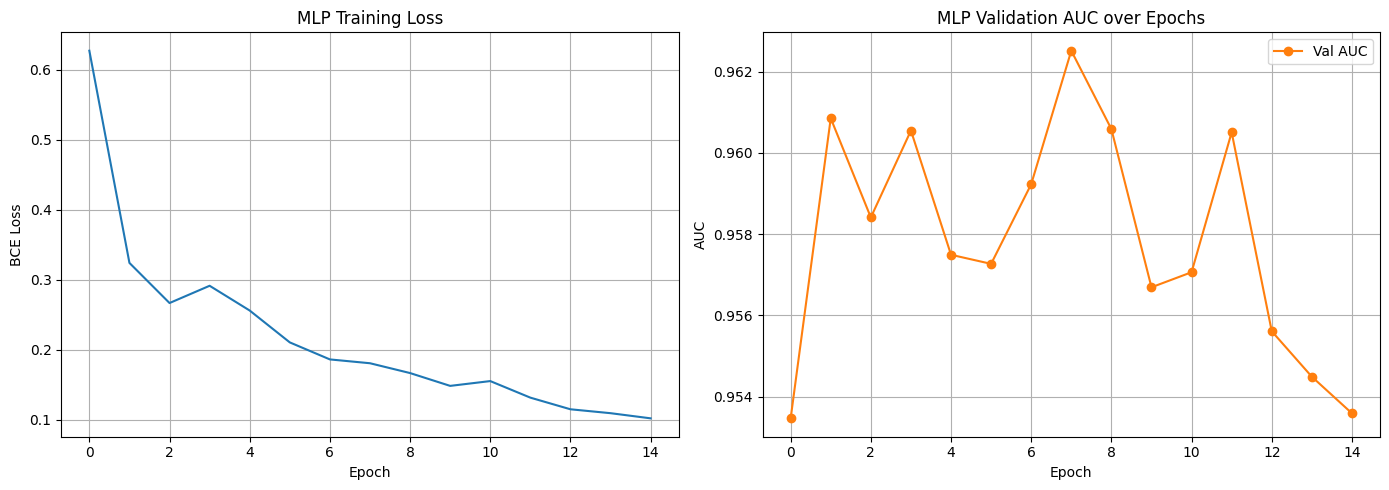

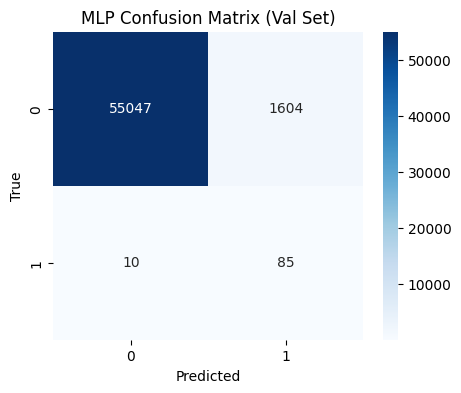

In [13]:
# CELL 13: MLP Final Evaluation & Comparison
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve

# Final predictions
model.eval()
with torch.no_grad():
    val_logits = model(X_val_tensor.to(device))
    val_proba_mlp = torch.sigmoid(val_logits).cpu().numpy().ravel()
    val_pred_mlp  = (val_proba_mlp >= 0.5).astype(int)

# MLP Metrics
auc_mlp = roc_auc_score(y_val, val_proba_mlp)
prec_mlp = precision_score(y_val, val_pred_mlp)
rec_mlp  = recall_score(y_val, val_pred_mlp)
f1_mlp   = f1_score(y_val, val_pred_mlp)

print("FINAL RESULTS")
print(f"{'Model':<20} {'AUC':<8} {'Precision':<10} {'Recall':<8} {'F1':<8}")
print("-" * 60)
print(f"{'Logistic Regression':<20} {'~0.937':<8} {'~0.05':<10} {'~0.88':<8} {'~0.10':<8}")
print(f"{'XGBoost':<20} {0.9770:<8.4f} {0.7379:<10.4f} {0.8000:<8.4f} {0.7677:<8.4f}")
print(f"{'PyTorch MLP':<20} {auc_mlp:<8.4f} {prec_mlp:<10.4f} {rec_mlp:<8.4f} {f1_mlp:<8.4f}")
print("\nXGBoost is the WINNER")

# Plot Loss & AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss', color='tab:blue')
ax1.set_title('MLP Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('BCE Loss')
ax1.grid(True)

ax2.plot(val_aucs, label='Val AUC', color='tab:orange', marker='o')
ax2.set_title('MLP Validation AUC over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix for MLP
cm_mlp = confusion_matrix(y_val, val_pred_mlp)
plt.figure(figsize=(5,4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix (Val Set)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [14]:
# CELL 14: Save FINAL BEST MODEL (XGBoost) + metadata
import joblib
import os
from datetime import datetime

final_model_path = "/content/drive/MyDrive/Data Science course/Major Projects/Projects/Credit Card Fraud Detection/Credit Card Fraud Detection/models/BEST_XGBOOST_MODEL.pkl"

os.makedirs(os.path.dirname(final_model_path), exist_ok=True)

# Save the actual booster (bst) we trained with xgb.train()
joblib.dump({
    'model': bst,                              # the real trained booster
    'model_type': 'xgboost_booster',
    'auc': 0.9770,
    'precision': 0.7379,
    'recall': 0.8000,
    'f1': 0.7677,
    'best_iteration': 122,
    'feature_names': feature_cols,
    'saved_on': datetime.now().strftime("%Y-%m-%d %H:%M"),
    'note': 'Best model from full experiment - beats Logistic & MLP'
}, final_model_path)

print(f"FINAL BEST MODEL SAVED:")
print(f"→ {final_model_path}")
print("Ready for 04_best_model_finalize.ipynb & FastAPI deployment!")

FINAL BEST MODEL SAVED:
→ /content/drive/MyDrive/Data Science course/Major Projects/Projects/Credit Card Fraud Detection/Credit Card Fraud Detection/models/BEST_XGBOOST_MODEL.pkl
Ready for 04_best_model_finalize.ipynb & FastAPI deployment!
